<a href="https://colab.research.google.com/github/dejunga/ML-Vehicle_Image_Classification/blob/main/cifar10_vgg16_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, MaxPool2D, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# **Load the dataset**

In [2]:
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Define the desired labels (airplane, automobile, ship, and truck)
classes_name = ['airplane', 'automobile', 'ship', 'truck']
desired_indices = [labels.index(label) for label in classes_name]

# Filter the training dataset to include only images with the desired labels
mask_train = np.isin(y_train, desired_indices).flatten()
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# Filter the test dataset to include only images with the desired labels
mask_test = np.isin(y_test, desired_indices).flatten()
X_test = X_test[mask_test]
y_test = y_test[mask_test]

# Print the shapes of the filtered datasets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 2s 0us/step
X_train shape: (20000, 32, 32, 3)
y_train shape: (20000, 1)
X_test shape: (4000, 32, 32, 3)
y_test shape: (4000, 1)


# **Data visualization**

<ipython-input-3-599ce121c7ca>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


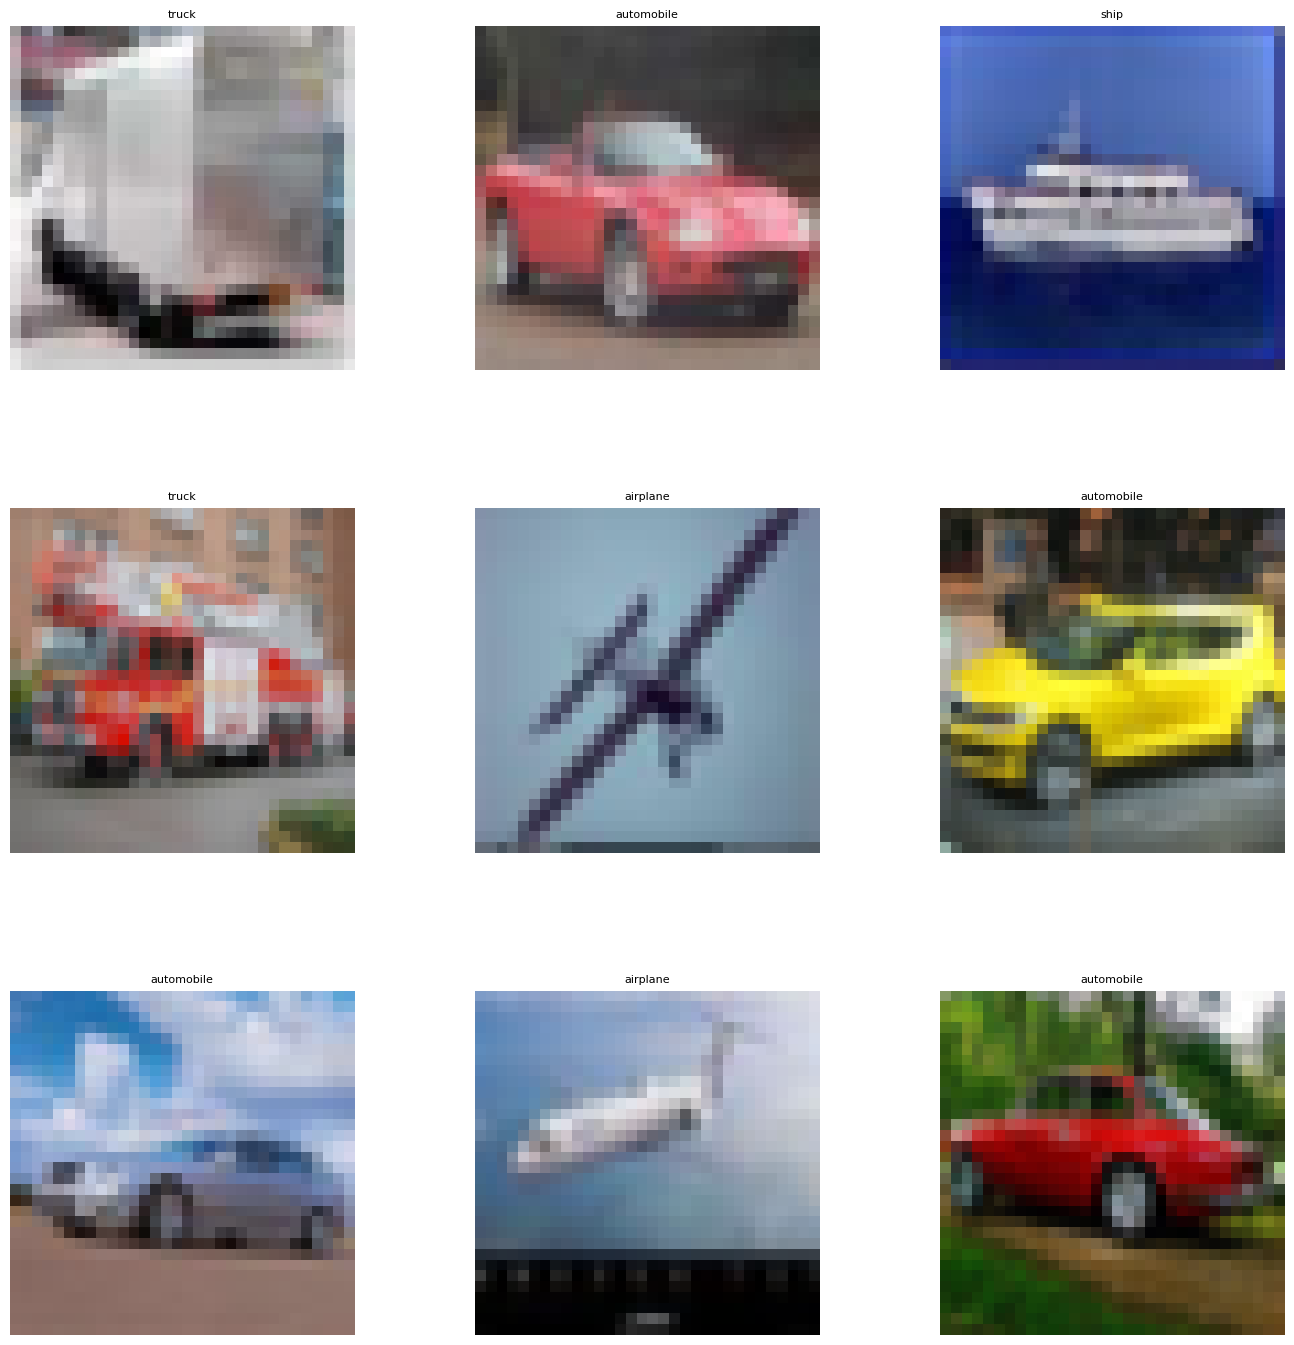

In [3]:
W_grid = 3
L_grid = 3

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()  # Flatten the 10 x 10 matrix into 100 array

n_filtered = len(X_train)  # get the length of the filtered dataset

# Select a random number from 0 to n_filtered
for i in np.arange(0, W_grid * L_grid):  # create evenly spaced variables

    # Select a random number
    index = np.random.randint(0, n_filtered)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index])

    # Get the corresponding label index
    label_index = int(y_train[index])

    # Display the corresponding label name
    axes[i].set_title(labels[label_index], fontsize=8)

    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)
plt.show()

Text(0.5, 1.0, 'Class distribution in training set')

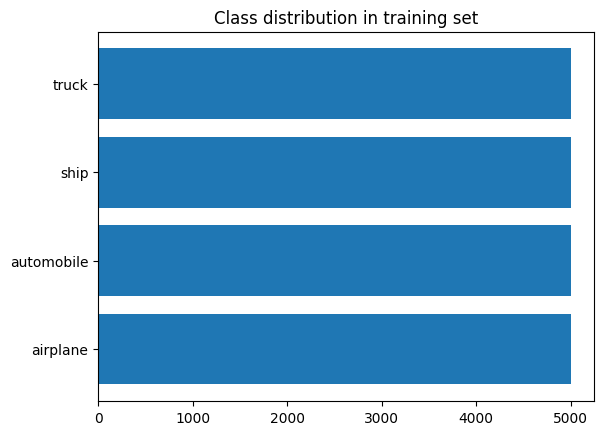

In [4]:
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

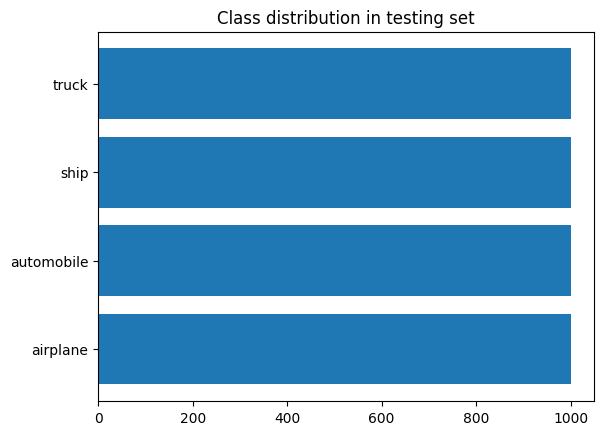

In [5]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

# **Data preprocessing**

In [6]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

# **Model Building**

In [7]:
# VGG16 base model, without the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Custom VGG16 model with the same layer naming as the custom CNN
model_vgg16 = Sequential(name="VGG16_custom")

# Add VGG16 base model (pre-trained on ImageNet)
model_vgg16.add(vgg16_base)

# Flatten the output from VGG16
model_vgg16.add(Flatten(name="flatten"))

# Fully connected layer with 128 units, just like the custom CNN
model_vgg16.add(Dense(128, activation='relu', name="dense_128"))
model_vgg16.add(Dropout(0.25, name="dropout_0.25"))

# Output layer: 10 units (for CIFAR-10 classes)
model_vgg16.add(Dense(10, activation='softmax', name="dense_output"))

# Freeze the VGG16 layers
vgg16_base.trainable = False

# Compile the model using the same metrics
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model_vgg16.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=METRICS)

# Data augmentation
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

# Train the VGG16 model for 50 epochs
history_vgg16 = model_vgg16.fit(train_generator,
                                epochs=50,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=(X_test, y_cat_test))

# Model summary to check layer names and structure
model_vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
625/625 [==============================] - 29s 45ms/step - loss: 0.9126 - accuracy: 0.6231 - precision: 0.7131 - recall: 0.4922 - val_loss: 0.7220 - val_accuracy: 0.7090 - val_precision: 0.7781 - val_recall: 0.6223
Epoch 2/50
625/625 [==============================] - 28s 45ms/step - loss: 0.7678 - accuracy: 0.6914 - precision: 0.7489 - recall: 0.6051 - val_loss: 0.6970 - val_accuracy: 0.7228 - val_precision: 0.7717 - val_recall: 0.6490
Epoch 3/50
625/625 [==============================] - 28s 44ms/step - loss: 0.7372 - accuracy: 0.7045 - precision: 0.7627 - recall: 0.6287 - val_loss: 0.6998 - val_accuracy: 0.7197 - val_precision: 0.7625 - val_recall: 0.6580
Epoch 4/50
625/625 [==============================] - 28s 44ms/step - loss: 0.7090 - accuracy: 0.7152 - precision: 0.7669 - recall: 0.6450 - val_loss: 0.6925 - val_accuracy: 0.7168 - val_precision: 0.7739 - val_recall: 0.6528
Epoch 5/50
625/625 [===========

# **Model Evaluation**

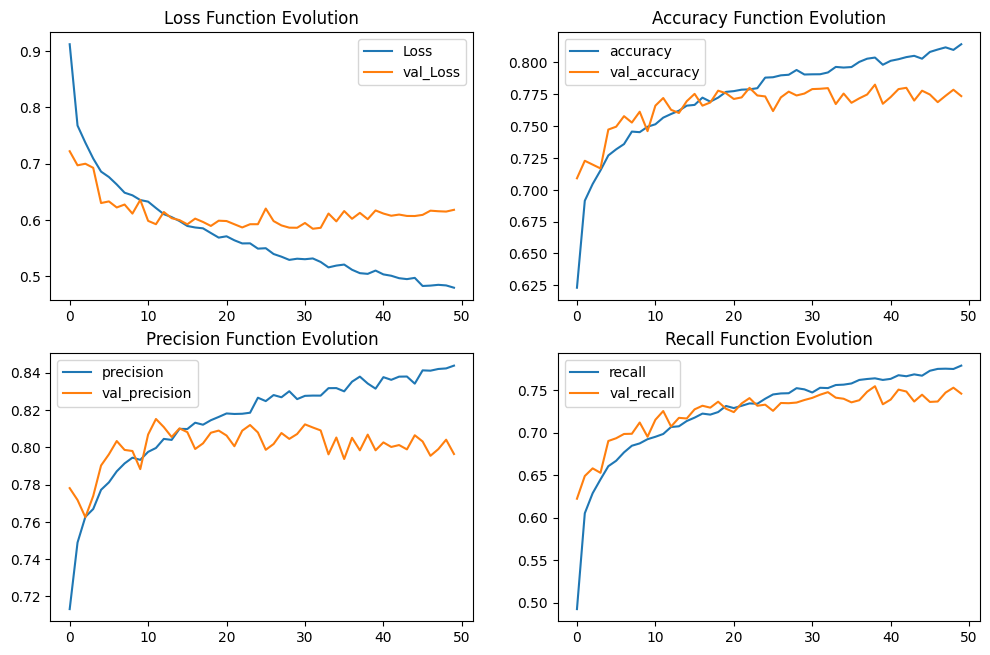

In [8]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history_vgg16.history['loss'], label='Loss')
plt.plot(history_vgg16.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history_vgg16.history['precision'], label='precision')
plt.plot(history_vgg16.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history_vgg16.history['recall'], label='recall')
plt.plot(history_vgg16.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

125/125 [==============================] - 5s 36ms/step - loss: 0.6177 - accuracy: 0.7735 - precision: 0.7964 - recall: 0.7460
Test Accuracy : 77.35%
125/125 [==============================] - 5s 35ms/step


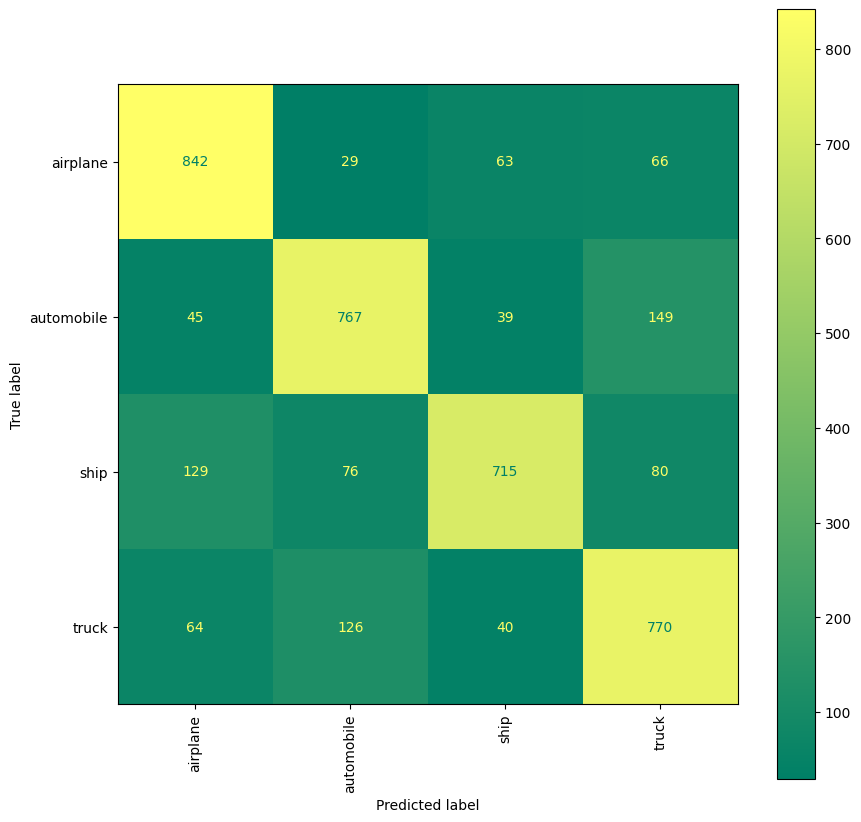

In [9]:
evaluation = model_vgg16.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model_vgg16.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_name)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1000
           1       0.77      0.77      0.77      1000
           8       0.83      0.71      0.77      1000
           9       0.72      0.77      0.75      1000

    accuracy                           0.77      4000
   macro avg       0.78      0.77      0.77      4000
weighted avg       0.78      0.77      0.77      4000



# **Test on one image**

Image 100 is 1 (automobile)
1/1 [==============================] - 0s 149ms/step
The model predicts that image 100 is 1 - (automobile)


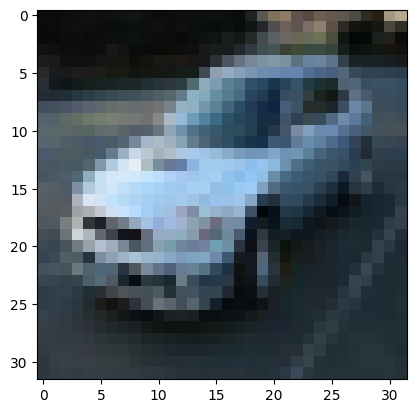

In [13]:
my_image = X_test[100]
plt.imshow(my_image)

true_label = y_test[100][0]
print(f"Image 100 is {true_label} ({labels[true_label]})")

pred_100 = np.argmax(model_vgg16.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predicts that image 100 is {pred_100} - ({labels[pred_100]})")